# Rotation Method Birefringence Analysis

## Preliminary Setup

Run all blocks in this section.

### Imports

Run this block first.

In [1]:
import pandas as pd
import IPython.display as dis
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
import pathlib as pl
from analysis import *
import qexpy as q
import qexpy.plotting as qplt

### Config

Usage: make necessary configurations then run all cells below it. 

In [2]:
##########
# Config #
##########

# Sets name of sample on plots
sample_name = "Baby Interferometer Right"
# Sets filename to save, relevant only if save_figures = True
folder_name = "baby-interferometer-right"
# Saves the plot to file if True
save_figures = True
# Renders labels within pcolormesh plots for each value
draw_box_labels = False
# Extension to append to filename for more details (i.e. small area)
# Be sure to inclue an '_' at the beginning of the string if it is not blank.
name_extension = ""
# Sets the size of the figures. Accepts tuples in the form (x, y).
figure_size = None

# Slice of data to be plotted in the x and y direction.
# Specify a tuple of start and stop to plot a smaller region.
# Defaults to None, which includes all data.
x_slice = slice(None)
y_slice = slice(None)

# Creates Folder if does not yet exist
pl.Path("figures/{}/rotation".format(folder_name)).mkdir(parents=True, exist_ok=True)

# Sets lambda, wavelength of light in m, default value of 1550nm should be fine. 
l = 1550e-9  
# Sets the thickness of the sample in m. Uncomment the correct one. 
# d = q.Measurement(14.46e-6, 1.88e-7) # thickness of 532nm quarter waveplate
d = q.Measurement(60e-6, 1e-6)  # thickness of machined sample 1
# d = 96.87e-06  # thickness of 1550nm quarter waveplate

# Sets the filenames of the data. Use one of the preset ones, or a custom needed. 

# 532nm Half Waveplate
# scan_name_aligned = "2022july14/waveplate_control_3_aligned_rotation_birefrigence_analysis__1740.csv"
# scan_name_antialigned = "2022july18/waveplate_control_3_antialigned_rotation_birefrigence_analysis__1532.csv"

# 532nm Quarter Waveplate
# scan_name_aligned = "2022june15/waveplate_control_aligned_rotation_stokes_birefringence_analysis__2152.csv"
# scan_name_antialigned = "2022june16/waveplate_control_antialigned_rotation_stokes_birefringence_analysis__0852.csv"

scan_name_aligned = "2022august16/baby_interferometer_right_aligned_rotation_0105.csv"
scan_name_antialigned = (
    "2022august17/baby_interferometer_right_antialigned_rotation_0203.csv"
)

## Read Power Meter Measurements

There is a commented out block below that you may want to uncomment to help troubleshoot errors. It will display the entire 2D transmittance plot at a given polarizer angle. 

In [3]:
# reads csv with pandas and stores everything in scan_df

scan_df_aligned = pd.read_csv(
    scan_name_aligned,
    usecols=[
        "Power - Mean [W]",
        "Power - Std. [W]",
        "G3 X Translation",
        "G3 Y Translation",
        "Polarizer [deg]",
        "Analyzer [deg]",
    ],
)

scan_df_antialigned = pd.read_csv(
    scan_name_antialigned,
    usecols=[
        "Power - Mean [W]",
        "Power - Std. [W]",
        "G3 X Translation",
        "G3 Y Translation",
        "Polarizer [deg]",
        "Analyzer [deg]",
    ],
)
# stores G3 (sample) x-axis positions
x_values = np.unique(scan_df_aligned["G3 X Translation"])
# stores G3 (sample) y-axis positions
y_values = np.unique(scan_df_aligned["G3 Y Translation"])
y_values = y_values[:-6]
# finds values of the polarizer and analyzers
polarizer_aligned_angle = np.unique(scan_df_aligned["Polarizer [deg]"])
analyzer_aligned_angle = np.unique(scan_df_aligned["Analyzer [deg]"])

polarizer_antialigned_angle = np.unique(scan_df_antialigned["Polarizer [deg]"])
analyzer_antialigned_angle = np.unique(scan_df_antialigned["Analyzer [deg]"])

power = []
deg = []
transmittance_array = np.empty([len(x_values), len(y_values)])
intensity_aligned = np.empty([len(x_values), len(y_values)])
intensity_antialigned = np.empty([len(x_values), len(y_values)])

for angle_aligned, angle_antialigned in zip(
    polarizer_aligned_angle, polarizer_antialigned_angle
):  # loop through polarizer angles

    # refreshes new power arrays
    power_array_aligned = []
    power_array_antialigned = []

    for x in x_values:  # loop through every x_value

        # list of all measured power values at a given angle
        power_aligned = []
        power_antialigned = []

        # print(scan_df['Power - Mean [W]'][scan_df('G1 Z Translation')])
        for y in y_values:  # loop through the y_values

            filters_aligned_dict = {
                "G3 Y Translation": y,
                "G3 X Translation": x,
                "Polarizer [deg]": angle_aligned,
            }
            filters_antialigned_dict = {
                "G3 Y Translation": y,
                "G3 X Translation": x,
                "Polarizer [deg]": angle_antialigned,
            }

            power_list_aligned = get_measurements(
                scan_df_aligned,
                "Power - Mean [W]",
                filters_aligned_dict,
            )
            power_list_antialigned = get_measurements(
                scan_df_antialigned,
                "Power - Mean [W]",
                filters_antialigned_dict,
            )
            error_list_aligned = get_measurements(
                scan_df_aligned,
                "Power - Std. [W]",
                filters_aligned_dict,
            )
            error_list_antialigned = get_measurements(
                scan_df_antialigned,
                "Power - Std. [W]",
                filters_antialigned_dict,
            )
            # print(power_list_aligned)
            # print(power_list_antialigned)

            power_temp_aligned = q.MeasurementArray(
                power_list_aligned, error_list_aligned
            )
            power_temp_antialigned = q.MeasurementArray(
                power_list_antialigned, error_list_antialigned
            )

            power_aligned.append(power_temp_aligned)
            power_antialigned.append(power_temp_antialigned)

        power_array_aligned.append(power_aligned)
        power_array_antialigned.append(power_antialigned)

    power_array_antialigned = np.asarray(power_array_antialigned)
    power_array_aligned = np.asarray(power_array_aligned)

    power_array = power_array_antialigned / (
        power_array_aligned + power_array_antialigned
    )

    dimensions = power_array.shape
    depolarization_plot = q.MeasurementArray(power_array_aligned.flatten()).values

    transmittance_array = np.dstack((transmittance_array, power_array))

""" # Plot the 2D Power Map
    fig = plt.figure(figsize=(8, 4), dpi=300)
    # shading='nearest' for grid, 'gouraud' for smooth, don't use 'flat'
    # cmap='viridis' or 'inferno'
    # flipped due to nature of motors (negative is up and to the right)
    # norm=colors.LogNorm: logarithmic normalization
    #     power_map = plt.pcolormesh(np.negative(x_values) * 0.25e-3, np.negative(y_values) * 0.05e-3, np.transpose(power_array),
    #                                norm=colors.LogNorm(vmax=0.25, vmin=2.5e-4), cmap='inferno', shading='nearest')
    power_map = plt.pcolormesh(
        np.negative(x_values[:]) * 0.25e-3,
        np.negative(y_values[:]) * 0.05e-3,
        np.transpose(depolarization_plot.reshape(dimensions[0:2])),
        cmap='inferno',
        shading='nearest',
        # vmin=0.,
        # vmax=0.1,
    )
    plt.title(
        "Machine Sample 1 Depolarization {} deg".format(np.round(angle_aligned, 4)),
        size=16,
    )
    plt.ylabel("G3 Y [mm]", size=12)
    plt.xlabel("G3 X [mm]", size=12)
    plt.colorbar.label = "Power [W]"
    plt.colorbar(power_map).ax.set_ylabel("Depolarization", size=12)
    #     plt.savefig("{}/machined_sample_1_transmittance_linear_{}_deg.png".format(date, angle_aligned))
    plt.show()
    # dis.clear_output(wait=True) """

x_len = len(x_values)
y_len = len(y_values)

## Curve Fitting

There is a commented out block below that you can uncomment to show the curvefits at each point. 

*Warning: extremely high ram usage. Program may crash unexpectedly. Proceed at your own risk.*

In [26]:
birefringence_angle = []
birefringence_intensity = []
depolarization = []
mean = []
for i in range(len(x_values)):
    for j in range(len(y_values)):
        # for some reason first value in transmittance_array is 2.000
        # ignore last element(360 deg) issues.
        # param, param_cov = curve_fit(
        #     cos_p90,

        #     p0=[4 / 3 *Quarter np.pi, 0.002, 0.0004],
        #     bounds=([-90, 1e-5, 1e-5], [90, 0.1, 0.1]),
        # )
        xydata = q.XYDataSet(
            xdata=np.arange(0, 185, 5),
            # xerr=0.001,
            xunit="deg",
            xname="angle",
            ydata=transmittance_array[i][j][1:],
            yunit="",
            yname="transmittance",
        )
        result = xydata.fit(
            model=transmittance,
            parguess=[np.pi / 4, 45, 0.01],
            bounds=([1e-5, 1e-5, 0], [2 * np.pi, 90, 1]),
        )
        b = result.params[0]
        a = result.params[1]
        D = result.params[2]
        # print(result.params)

        # Uncomment the following block to show curvefit plots
        """ fig = qplt.plot(xydata)
        fig.plot(result)
        fig.title = "({}, {}, beta: {}, alpha: {}, depolarization: {})".format(i, j, b * 180/np.pi, a, D)
        fig.show() """

        birefringence_angle.append(a)
        birefringence_intensity.append(b)
        depolarization.append(D)

# Convert Values
qalpha = q.MeasurementArray(birefringence_angle)
alpha = np.array(qalpha.values)
alpha = alpha.reshape(x_len, y_len)
qbeta = q.MeasurementArray(birefringence_intensity)
beta = np.array(qbeta.values)
beta = beta.reshape(x_len, y_len)
qdepolarization = q.MeasurementArray(depolarization)
depolarization = np.array(qdepolarization.values)
depolarization = depolarization.reshape(x_len, y_len)
# beta = np.arccos(1 - 2 * beta) * 180 / np.pi
# print(qbeta.values)

## Plot Generator

### Birefringence Plots

**Do not** modify the section below unless you know what you are doing. You may change vmin and vmax values as you see fit, as well as the cmap type. 

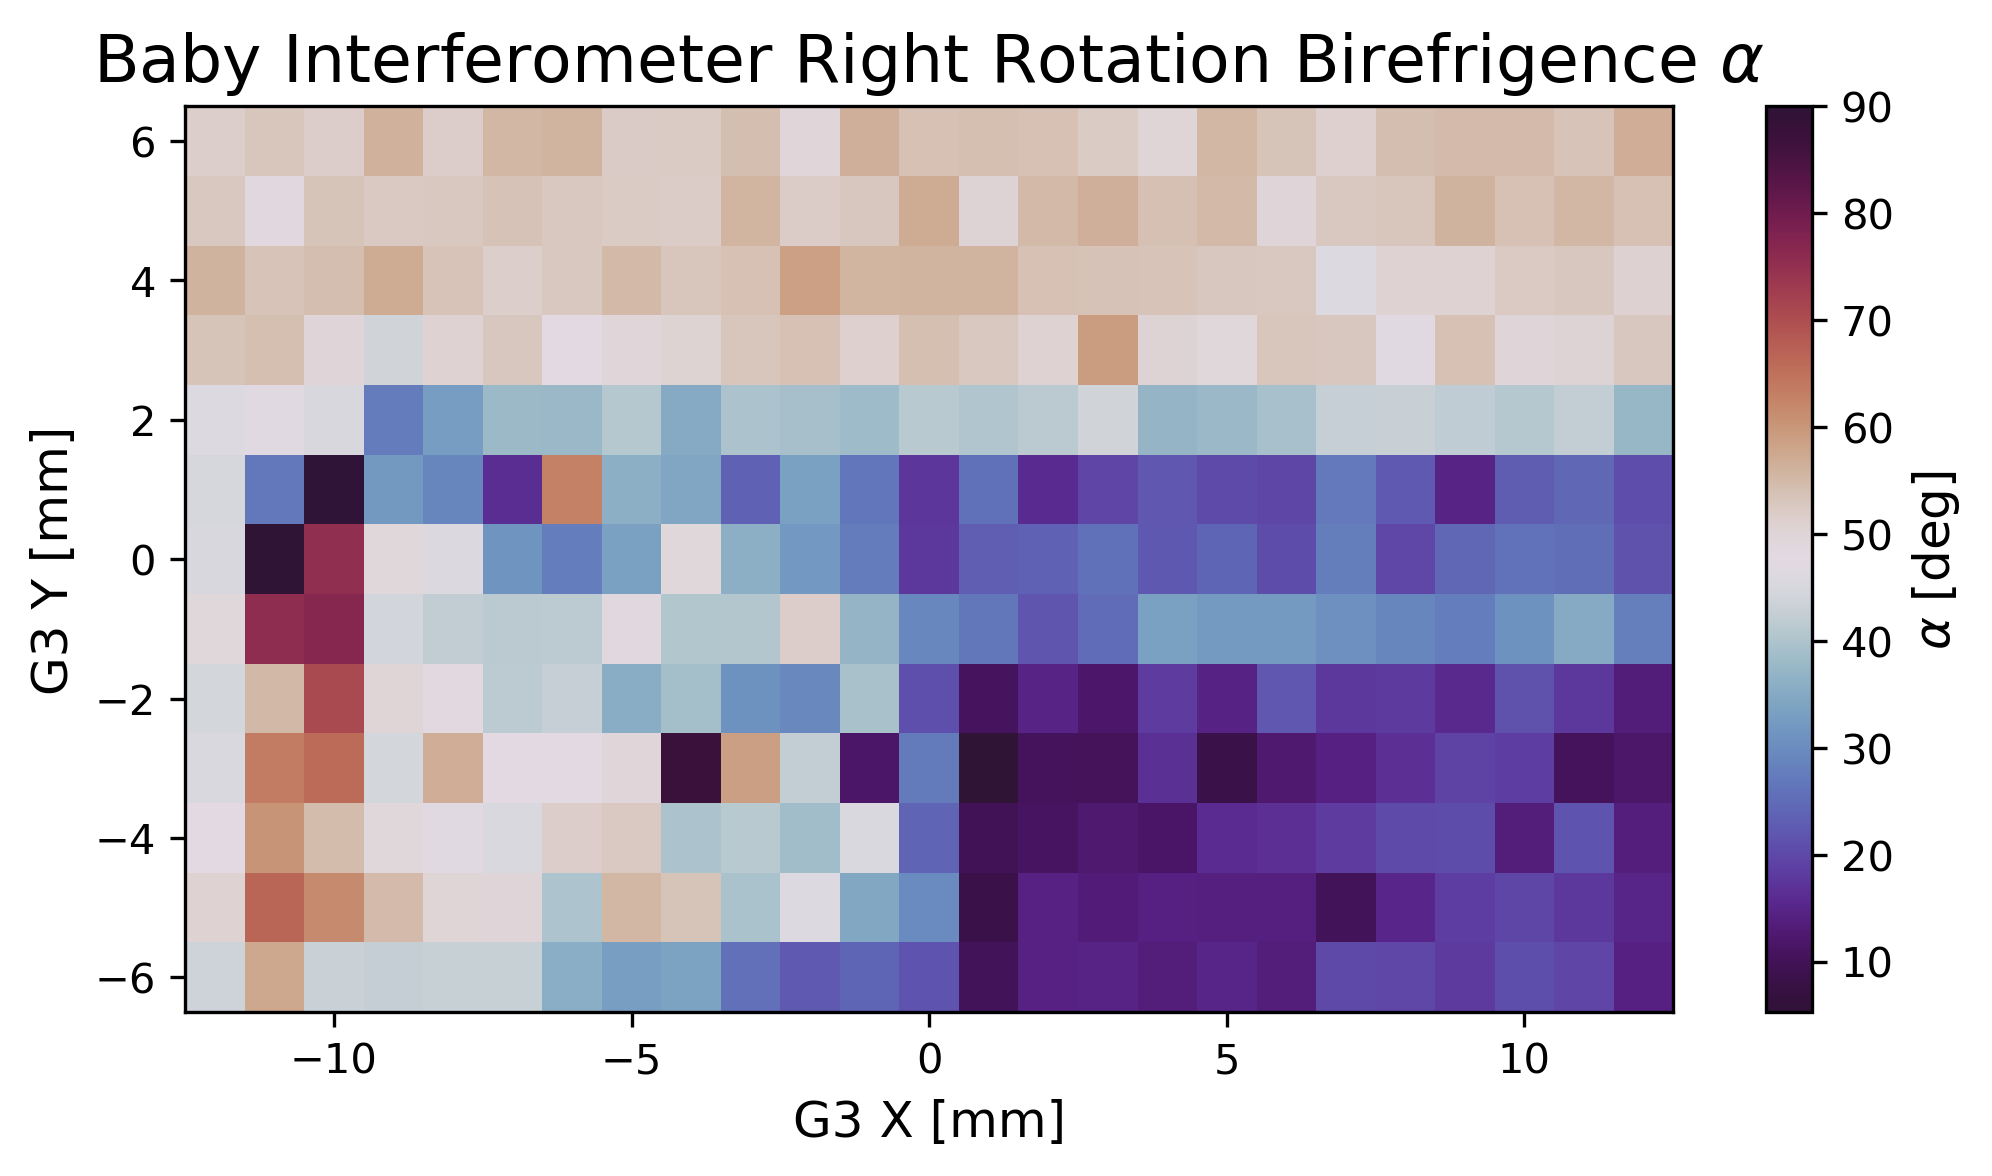

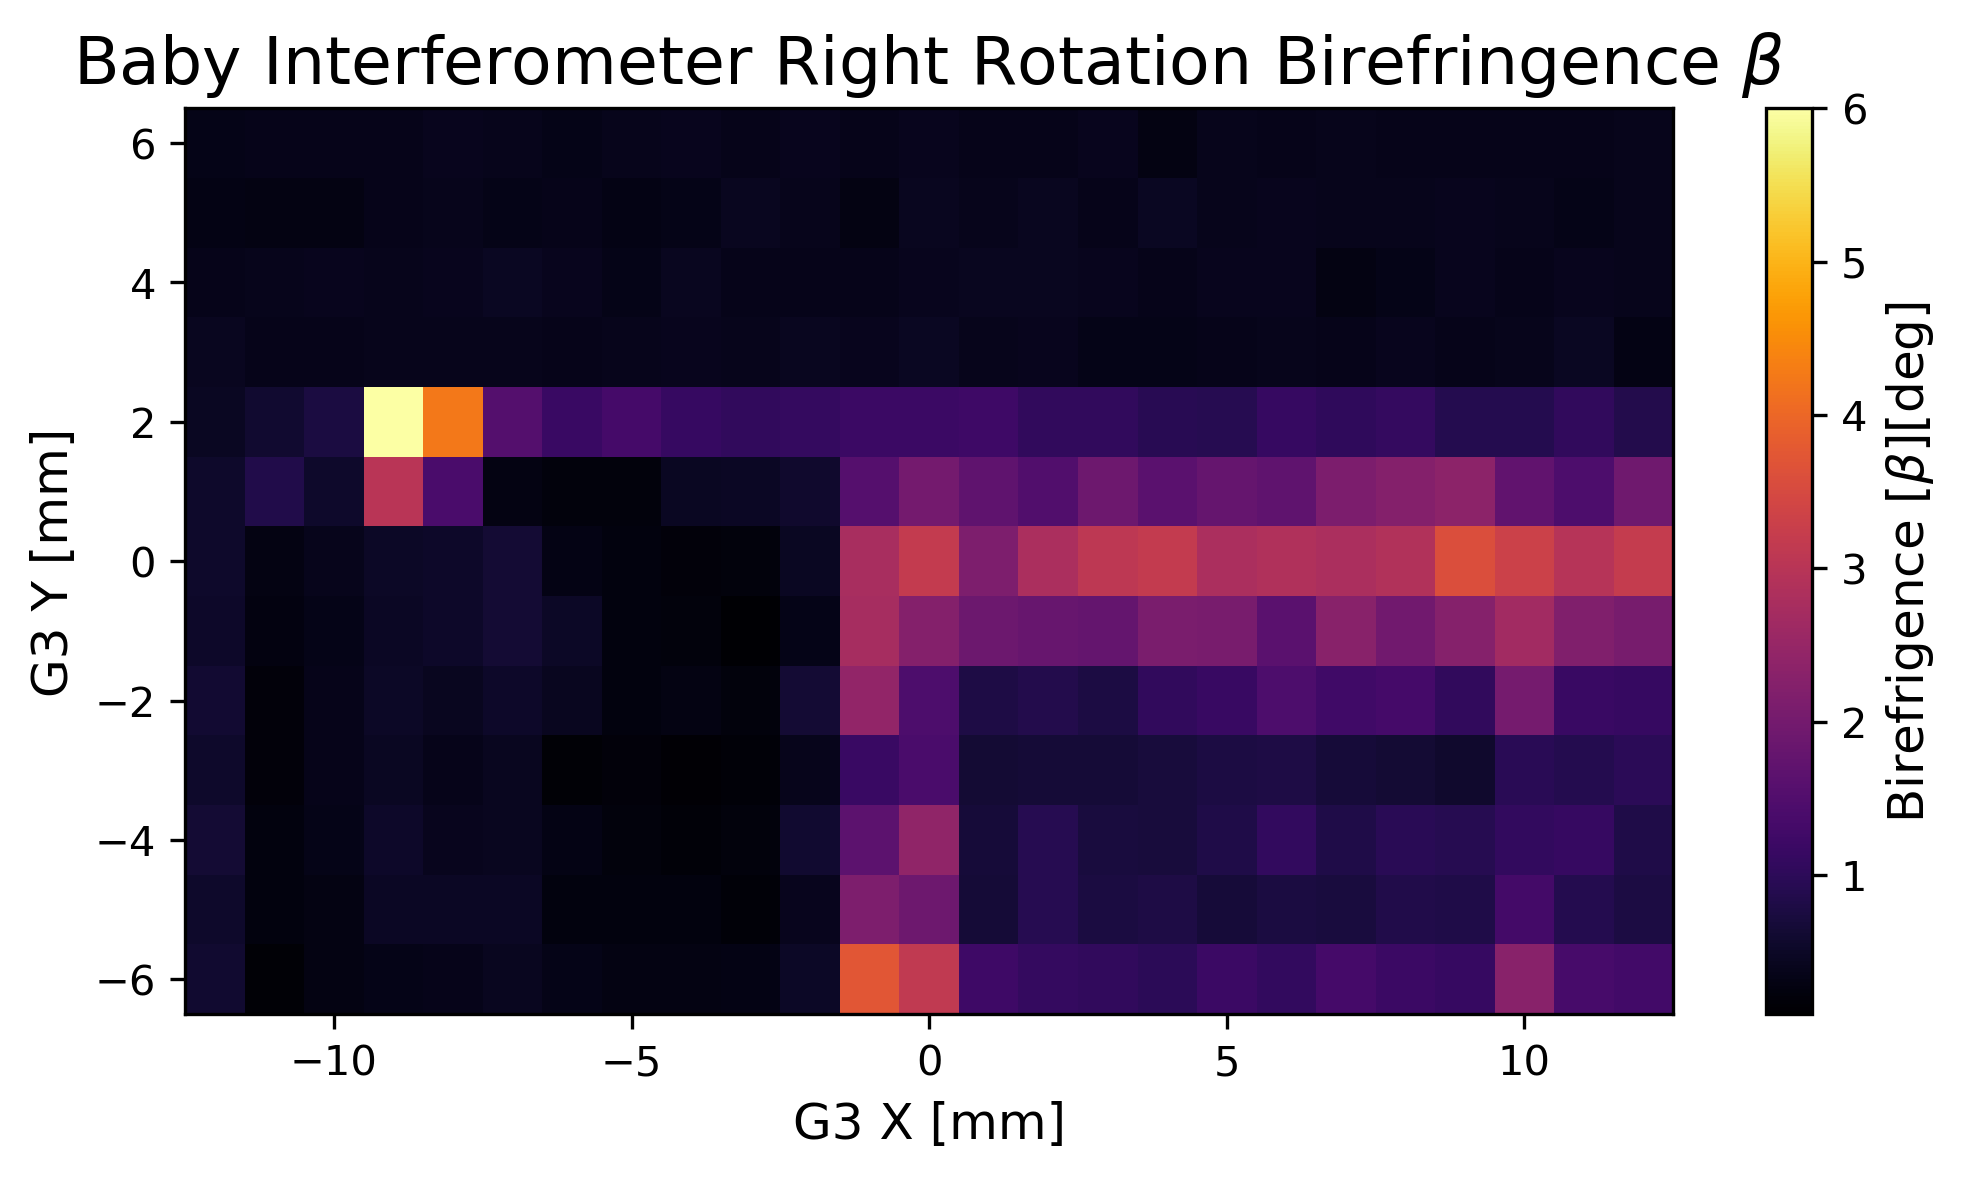

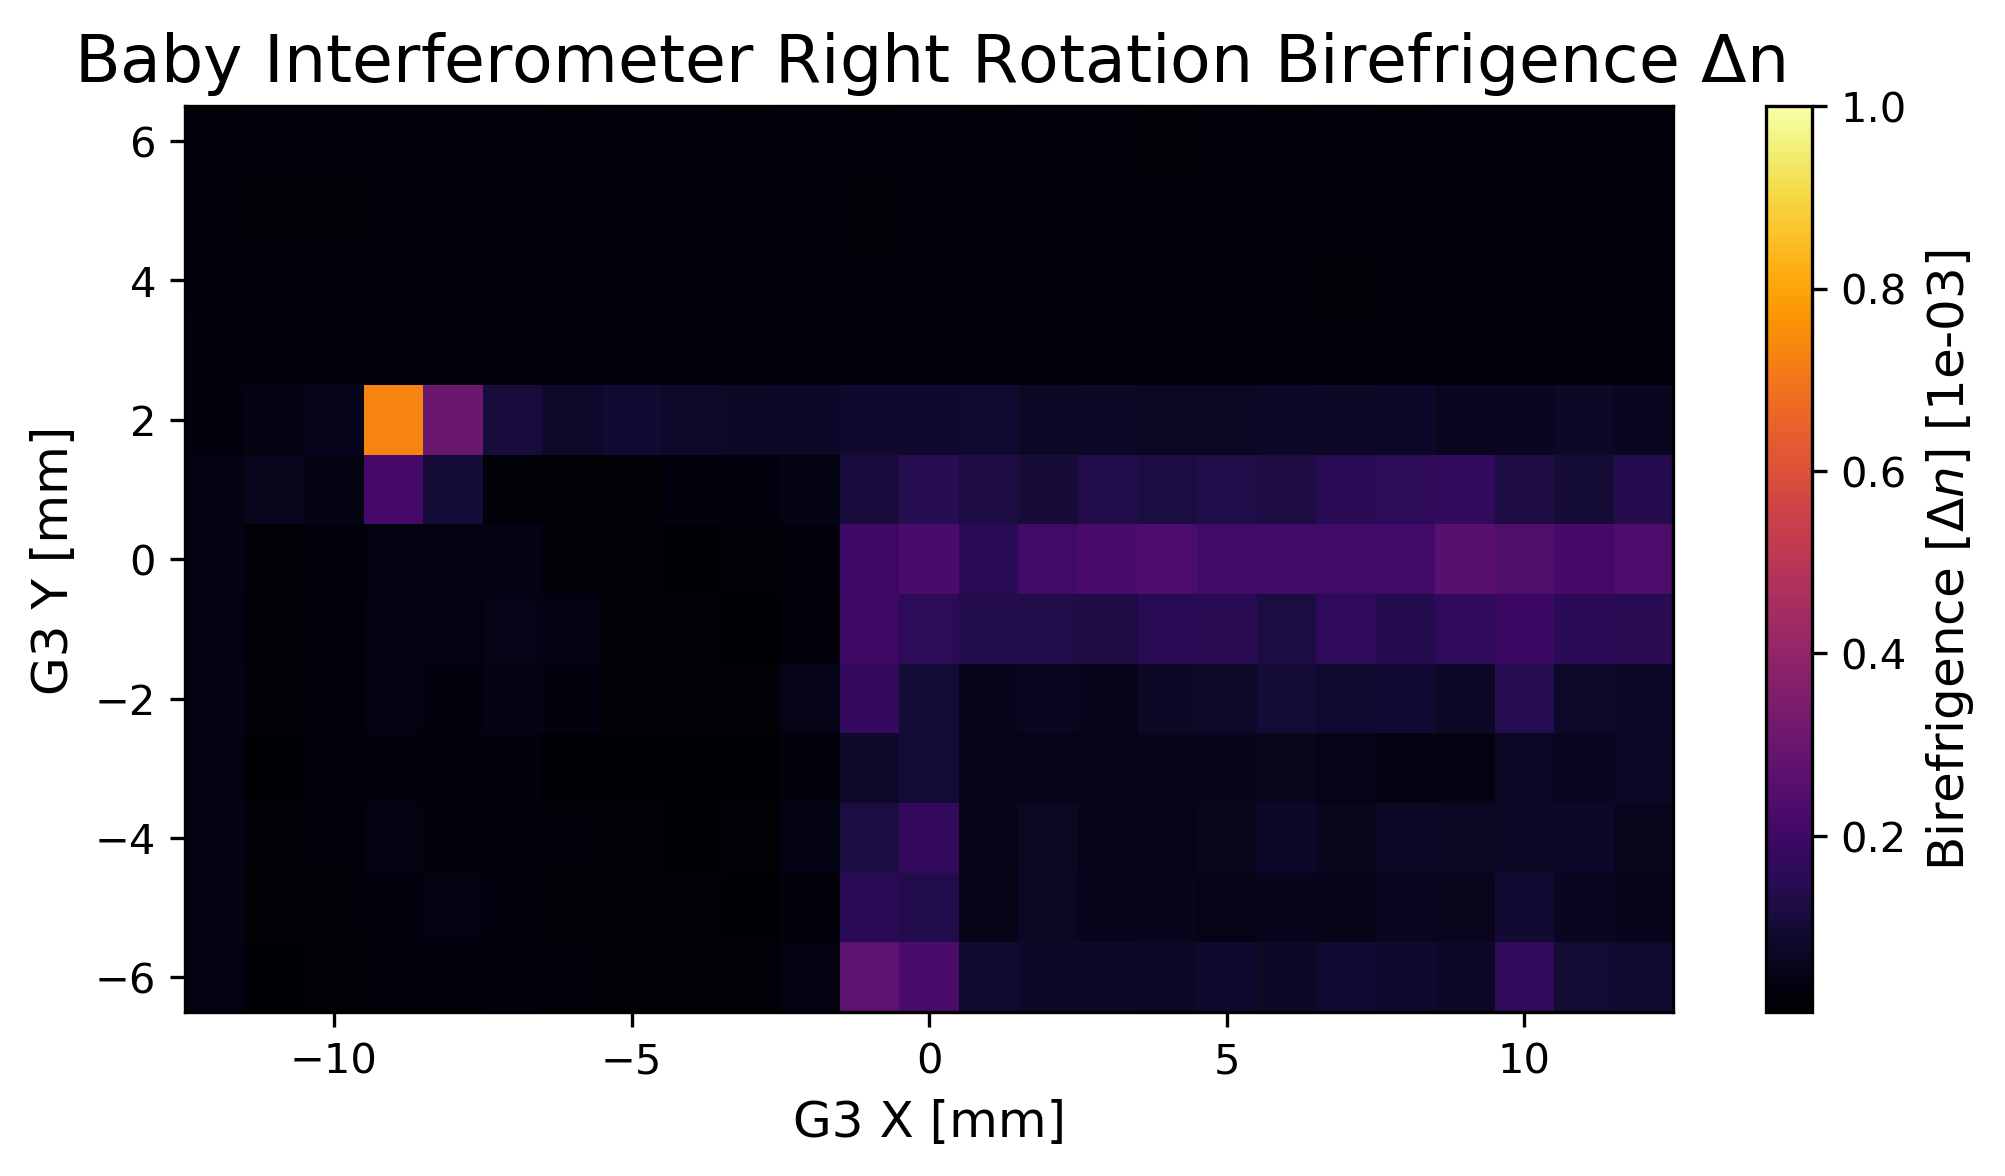

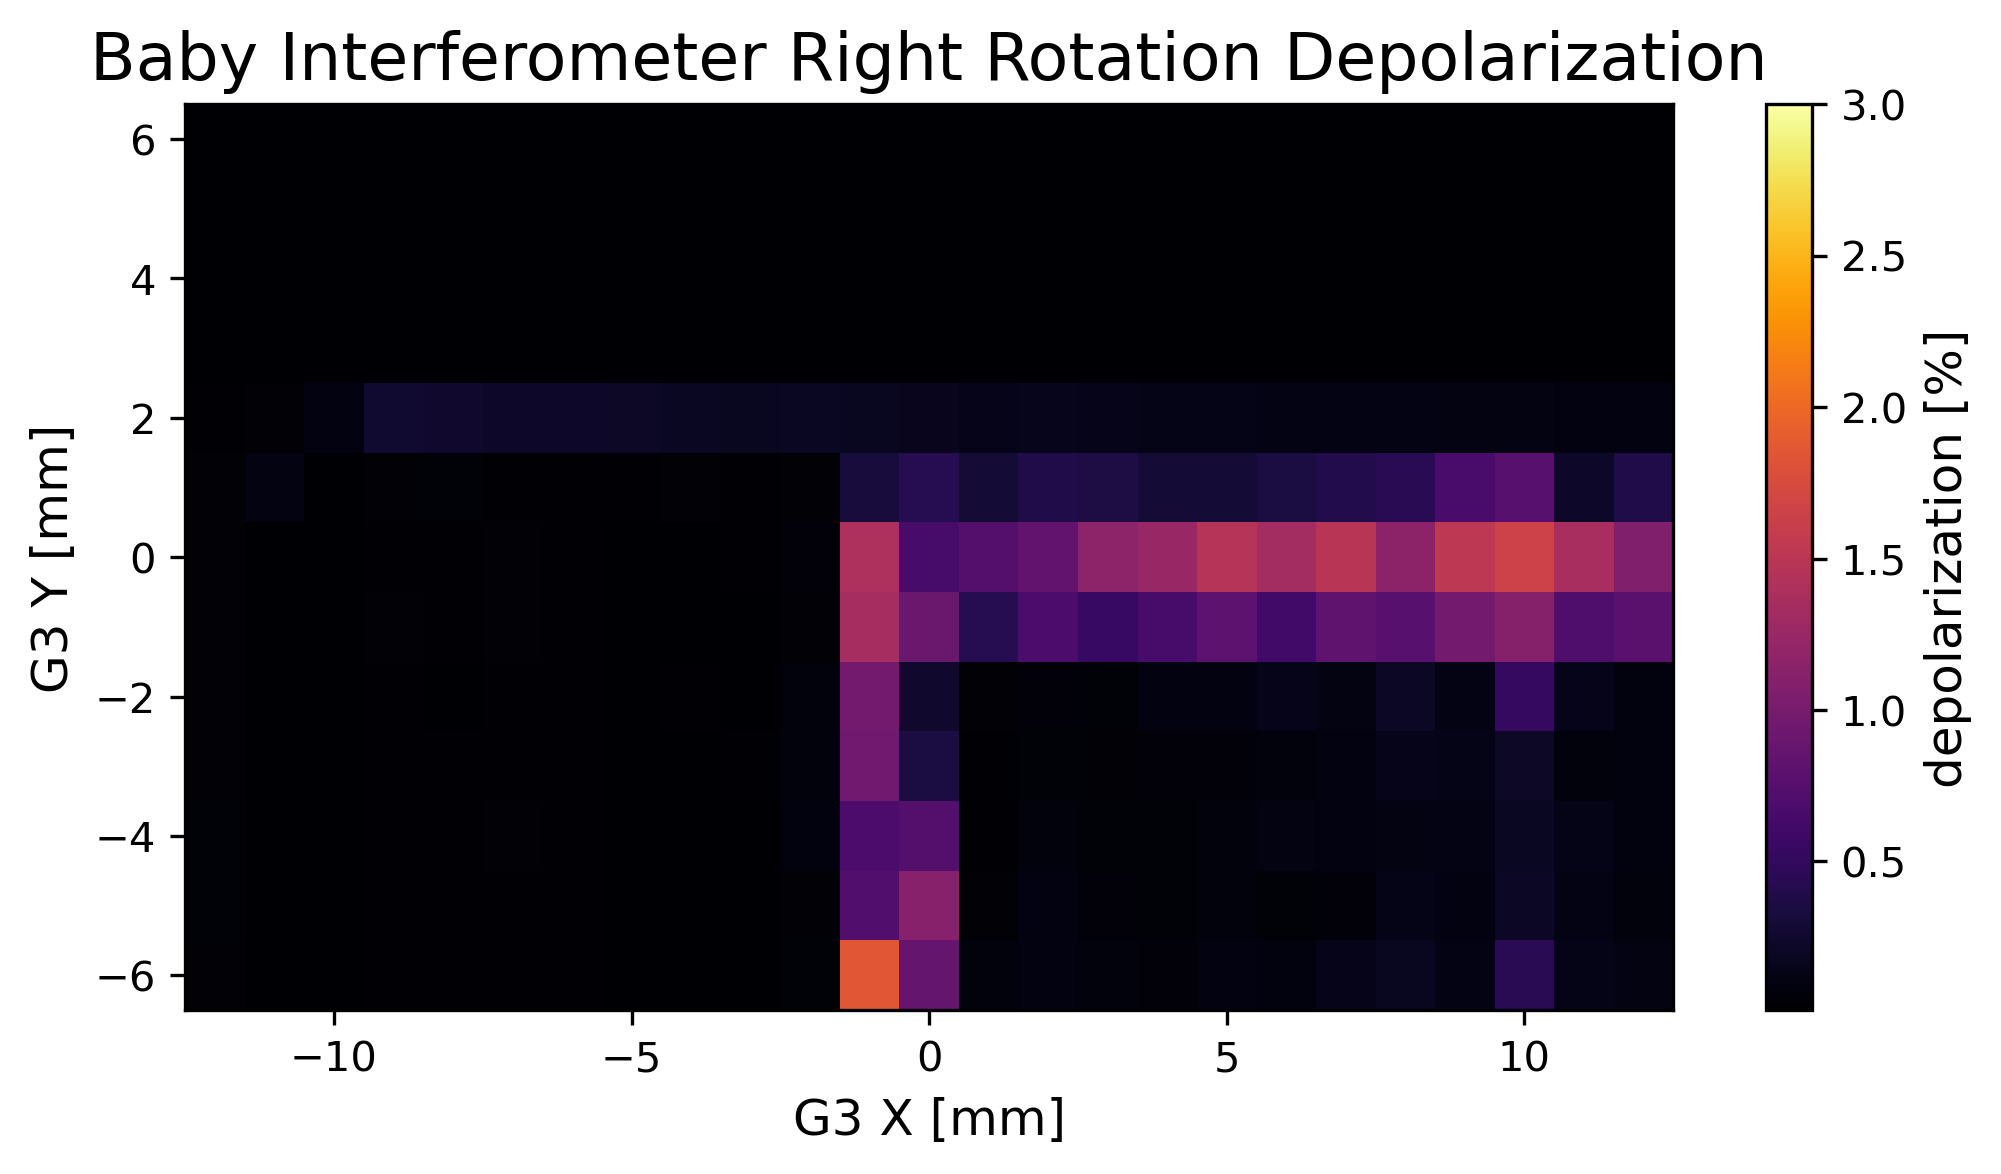

In [27]:
##############################
# Begin Plot - DO NOT MODIFY #
##############################

## Plot birefringence angle alpha

fig = plt.figure(figsize=figure_size, dpi=300)
alpha_map = plt.pcolormesh(
    np.negative(x_values[x_slice]) * 0.25e-3,
    np.negative(y_values[y_slice]) * 0.05e-3,
    np.transpose(alpha[x_slice, y_slice]),
    # 'bwr' for diverging, 'twilight' or 'hsv' for cyclic, 'twilight' default
    cmap="twilight_shifted",
    shading="nearest",
    # vmax=12,
    # vmin=0,
    # rasterized=True # Useful when saving figures as pdf to save space
)
# Prints Values in Boxes
if draw_box_labels:
    for (i, j), a in np.ndenumerate(
        np.transpose(np.reshape(np.array(qalpha), (x_len, y_len))[x_slice, y_slice])
    ):
        # a = q.acos(1 - b) * l / (2 * np.pi * d) / scaling
        plt.annotate(
            " {:.1f} \n+/- {:.1f}".format(a.value, a.error),
            (
                np.negative(x_values[x_slice])[j] * 0.25e-3,
                np.negative(y_values[y_slice])[i] * 0.05e-3,
            ),
            ha="center",
            va="center",
            size=4,
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.3"),
        )
plt.title(r"{} Rotation Birefrigence $\alpha$".format(sample_name), size=16)
plt.ylabel("G3 Y [mm]", size=12)
plt.xlabel("G3 X [mm]", size=12)
plt.colorbar(alpha_map).ax.set_ylabel(r"$\alpha$ [deg]", size=12)
if save_figures and draw_box_labels:
    plt.savefig(
        "figures/{}/rotation/birefringence_alpha_labeled{}.png".format(
            folder_name, name_extension
        ),
        facecolor="white",
    )
elif save_figures and not draw_box_labels:
    plt.savefig(
        "figures/{}/rotation/birefringence_alpha{}.png".format(
            folder_name, name_extension
        ),
        facecolor="white",
    )
plt.show()


## Plot birefringence beta

fig = plt.figure(figsize=figure_size, dpi=300)
beta_map = plt.pcolormesh(
    # np.negative(x_values[:-4]) * 0.25e-3,
    # np.negative(y_values[2:-1]) * 0.05e-3,
    # np.transpose(beta[4:, 2:-1]),
    np.negative(x_values[x_slice]) * 0.25e-3,
    np.negative(y_values[y_slice]) * 0.05e-3,
    np.transpose(beta[x_slice, y_slice]) * 180 / np.pi,
    cmap="inferno",
    shading="nearest",
    # vmin=0,
    # vmax=5,
    # rasterized=True # Useful when saving figures as pdf to save space
)
# Prints Values in Boxes
if draw_box_labels:
    for (i, j), b in np.ndenumerate(
        np.transpose(np.reshape(np.array(qbeta), (x_len, y_len))[x_slice, y_slice])
    ):
        # b = q.acos(1 - b) * 180 / np.pi
        b = b * 180 / np.pi
        plt.annotate(
            " {:.1f} \n+/- {:.1f}".format(b.value, b.error),
            (
                np.negative(x_values[x_slice])[j] * 0.25e-3,
                np.negative(y_values[y_slice])[i] * 0.05e-3,
            ),
            ha="center",
            va="center",
            size=4,
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.3"),
        )
plt.title(r"{} Rotation Birefringence $\beta$".format(sample_name), size=16)
plt.ylabel("G3 Y [mm]", size=12)
plt.xlabel("G3 X [mm]", size=12)
plt.colorbar(beta_map).ax.set_ylabel(r"Birefrigence $[\beta]$[deg]", size=12)
if save_figures and draw_box_labels:
    plt.savefig(
        "figures/{}/rotation/birefringence_beta_labeled{}.png".format(
            folder_name, name_extension
        ),
        facecolor="white",
    )
elif save_figures and not draw_box_labels:
    plt.savefig(
        "figures/{}/rotation/birefringence_beta{}.png".format(
            folder_name, name_extension
        ),
        facecolor="white",
    )
plt.show()


## Plot birefringence delta n

scaling = 1e-3
fig = plt.figure(figsize=figure_size, dpi=300)
birefringence_intensity_map = plt.pcolormesh(
    # np.negative(x_values[:-4]) * 0.25e-3,
    # np.negative(y_values[2:-1]) * 0.05e-3,
    # np.transpose((beta[4:, 2:-1]) * l / (2 * np.pi * d)),
    np.negative(x_values[x_slice]) * 0.25e-3,
    np.negative(y_values[y_slice]) * 0.05e-3,
    np.transpose(beta[x_slice, y_slice]) * l / (2 * np.pi * d.value) / scaling,
    cmap="inferno",
    shading="nearest",
    # vmin=7.5,
    # vmax=1,
    # rasterized=True # Useful when saving figures as pdf to save space
)
# Prints Values in Boxes
if draw_box_labels:
    for (i, j), k in np.ndenumerate(
        np.transpose(np.reshape(np.array(qbeta), (x_len, y_len))[x_slice, y_slice])
    ):
        k = k * l / (2 * np.pi * d) / scaling
        plt.annotate(
            " {:.2f} \n+/- {:.2f}".format(k.value, k.error),
            (
                np.negative(x_values[x_slice])[j] * 0.25e-3,
                np.negative(y_values[y_slice])[i] * 0.05e-3,
            ),
            ha="center",
            va="center",
            size=4,
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.3"),
        )
plt.title(r"{} Rotation Birefrigence $\Delta$n".format(sample_name), size=16)
plt.ylabel("G3 Y [mm]", size=12)
plt.xlabel("G3 X [mm]", size=12)
plt.colorbar(birefringence_intensity_map).ax.set_ylabel(
    r"Birefrigence $[\Delta n]$ [{:.0e}]".format(scaling), size=12
)
if save_figures and draw_box_labels:
    plt.savefig(
        "figures/{}/rotation/birefringence_delta_n_labeled{}.png".format(
            folder_name, name_extension
        ),
        facecolor="white",
    )
elif save_figures and not draw_box_labels:
    plt.savefig(
        "figures/{}/rotation/birefringence_delta_n{}.png".format(
            folder_name, name_extension
        ),
        facecolor="white",
    )
plt.show()


## Plot depolarization

fig = plt.figure(figsize=figure_size, dpi=300)
depolarization_map = plt.pcolormesh(
    # np.negative(x_values[:-4]) * 0.25e-3,
    # np.negative(y_values[2:-1]) * 0.05e-3,
    # np.transpose((beta[4:, 2:-1]) * l / (2 * np.pi * d)),
    np.negative(x_values[x_slice]) * 0.25e-3,
    np.negative(y_values[y_slice]) * 0.05e-3,
    np.transpose(depolarization[x_slice, y_slice]) * 100,  # show as percent
    cmap="inferno",
    shading="nearest",
    # vmin=0,
    # vmax=3,
    # rasterized=True # Useful when saving figures as pdf to save space
)
# Prints Values in Boxes
if draw_box_labels:
    for (i, j), k in np.ndenumerate(
        np.transpose(
            np.reshape(np.array(qdepolarization), (x_len, y_len))[x_slice, y_slice]
        )
    ):
        k *= 100  # convert to percent
        plt.annotate(
            " {:.2f} \n+/- {:.2f}".format(k.value, k.error),
            # (x_values[-(j + 1)] * 0.25e-3, y_values[-(i + 1)] * 0.05e-3),
            (
                np.negative(x_values[x_slice])[j] * 0.25e-3,
                np.negative(y_values[y_slice])[i] * 0.05e-3,
            ),
            ha="center",
            va="center",
            size=4,
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.3"),
        )
plt.title("{} Rotation Depolarization".format(sample_name), size=16)
plt.ylabel("G3 Y [mm]", size=12)
plt.xlabel("G3 X [mm]", size=12)
plt.colorbar(depolarization_map).ax.set_ylabel("depolarization [%]", size=12)
if save_figures and draw_box_labels:
    plt.savefig(
        "figures/{}/rotation/depolarization_labeled{}.png".format(
            folder_name, name_extension
        ),
        facecolor="white",
    )
elif save_figures and not draw_box_labels:
    plt.savefig(
        "figures/{}/rotation/depolarization{}.png".format(folder_name, name_extension),
        facecolor="white",
    )
plt.show()

### Intensity Plot Generator

Useful plot for showing the full scan area as well as where the sample resides. 

*Note: only helpful if the sample has some amount of reflectivity/absorption otherwise, nothing will show up.*

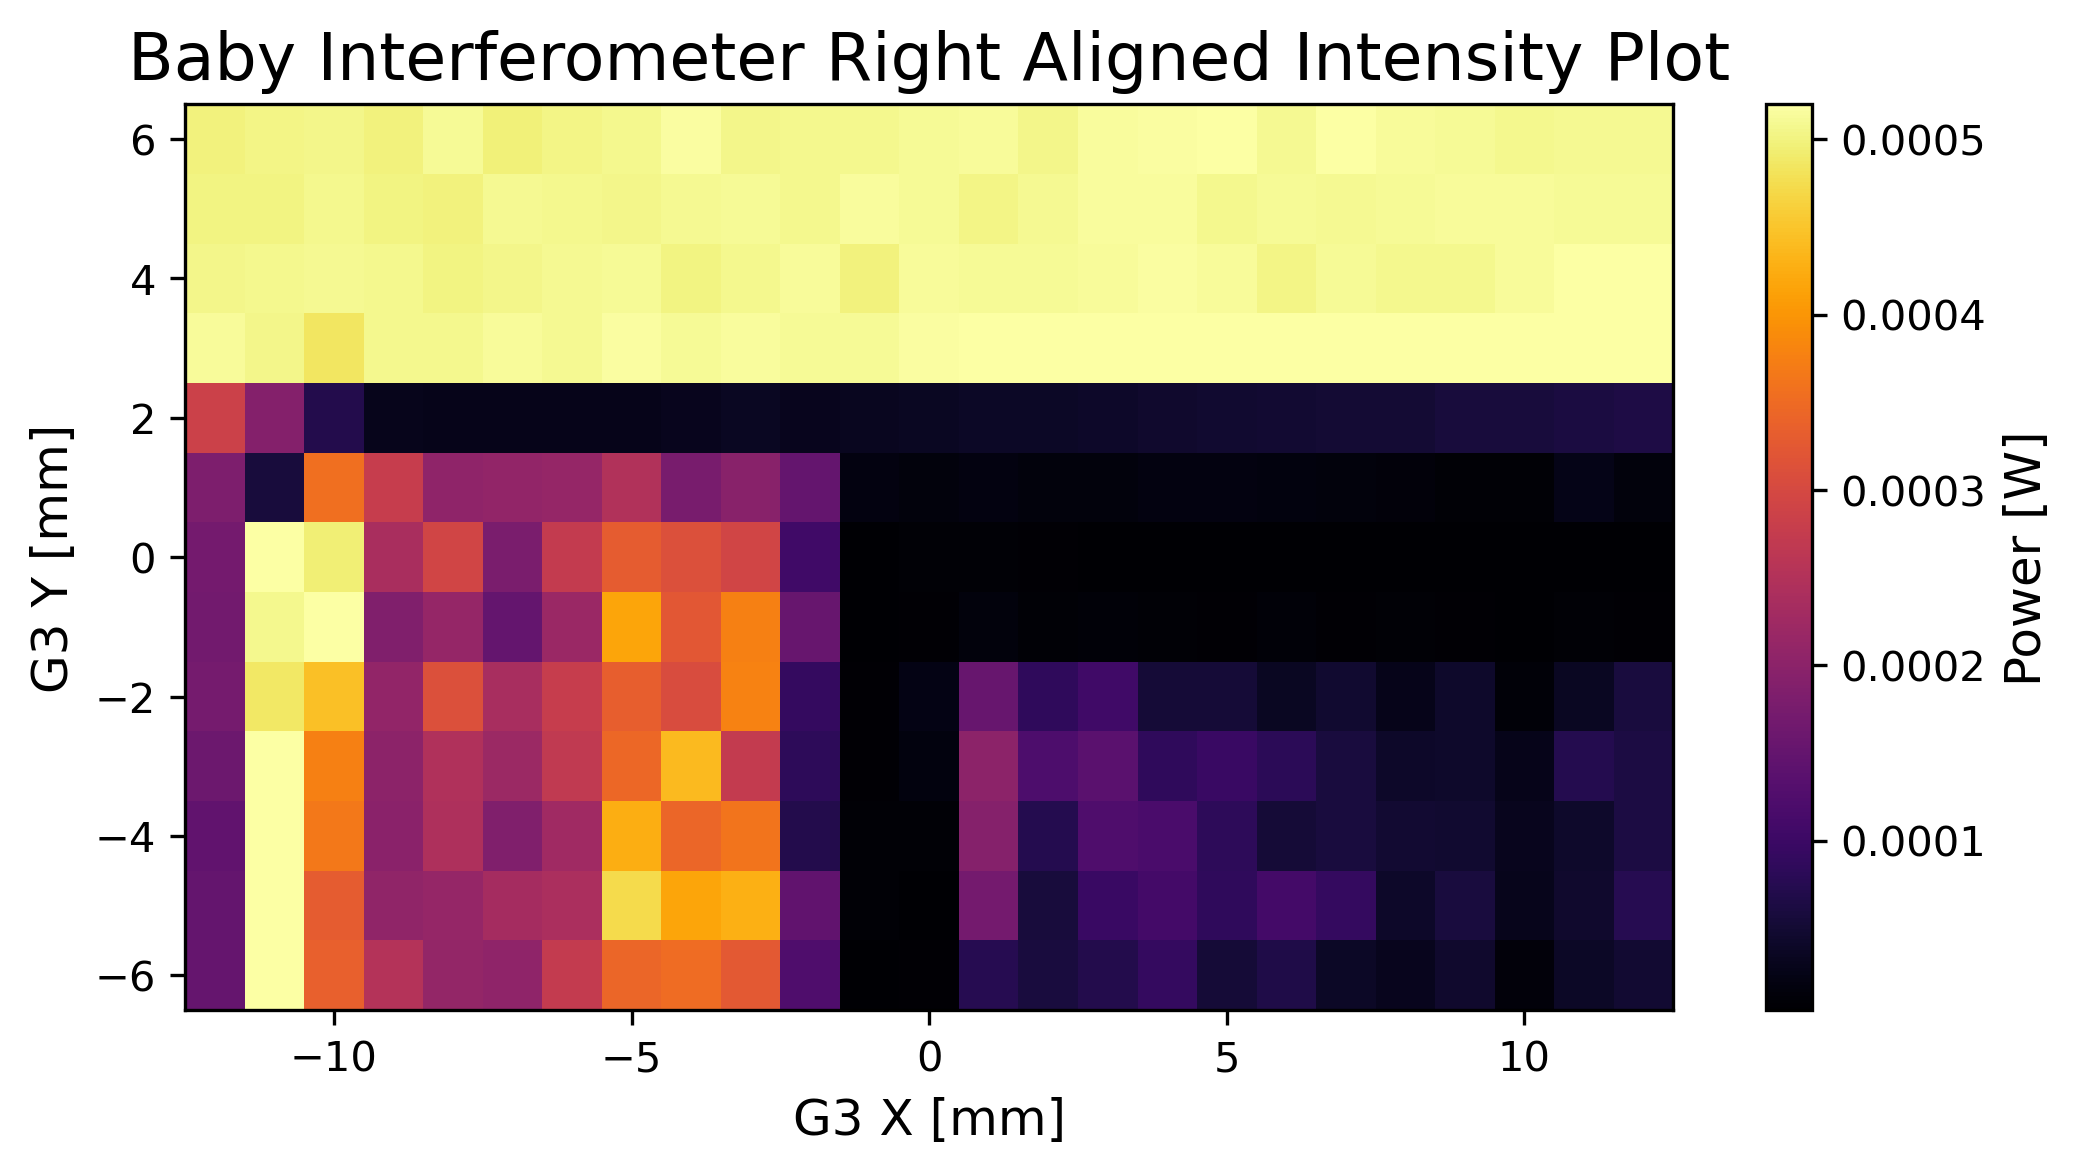

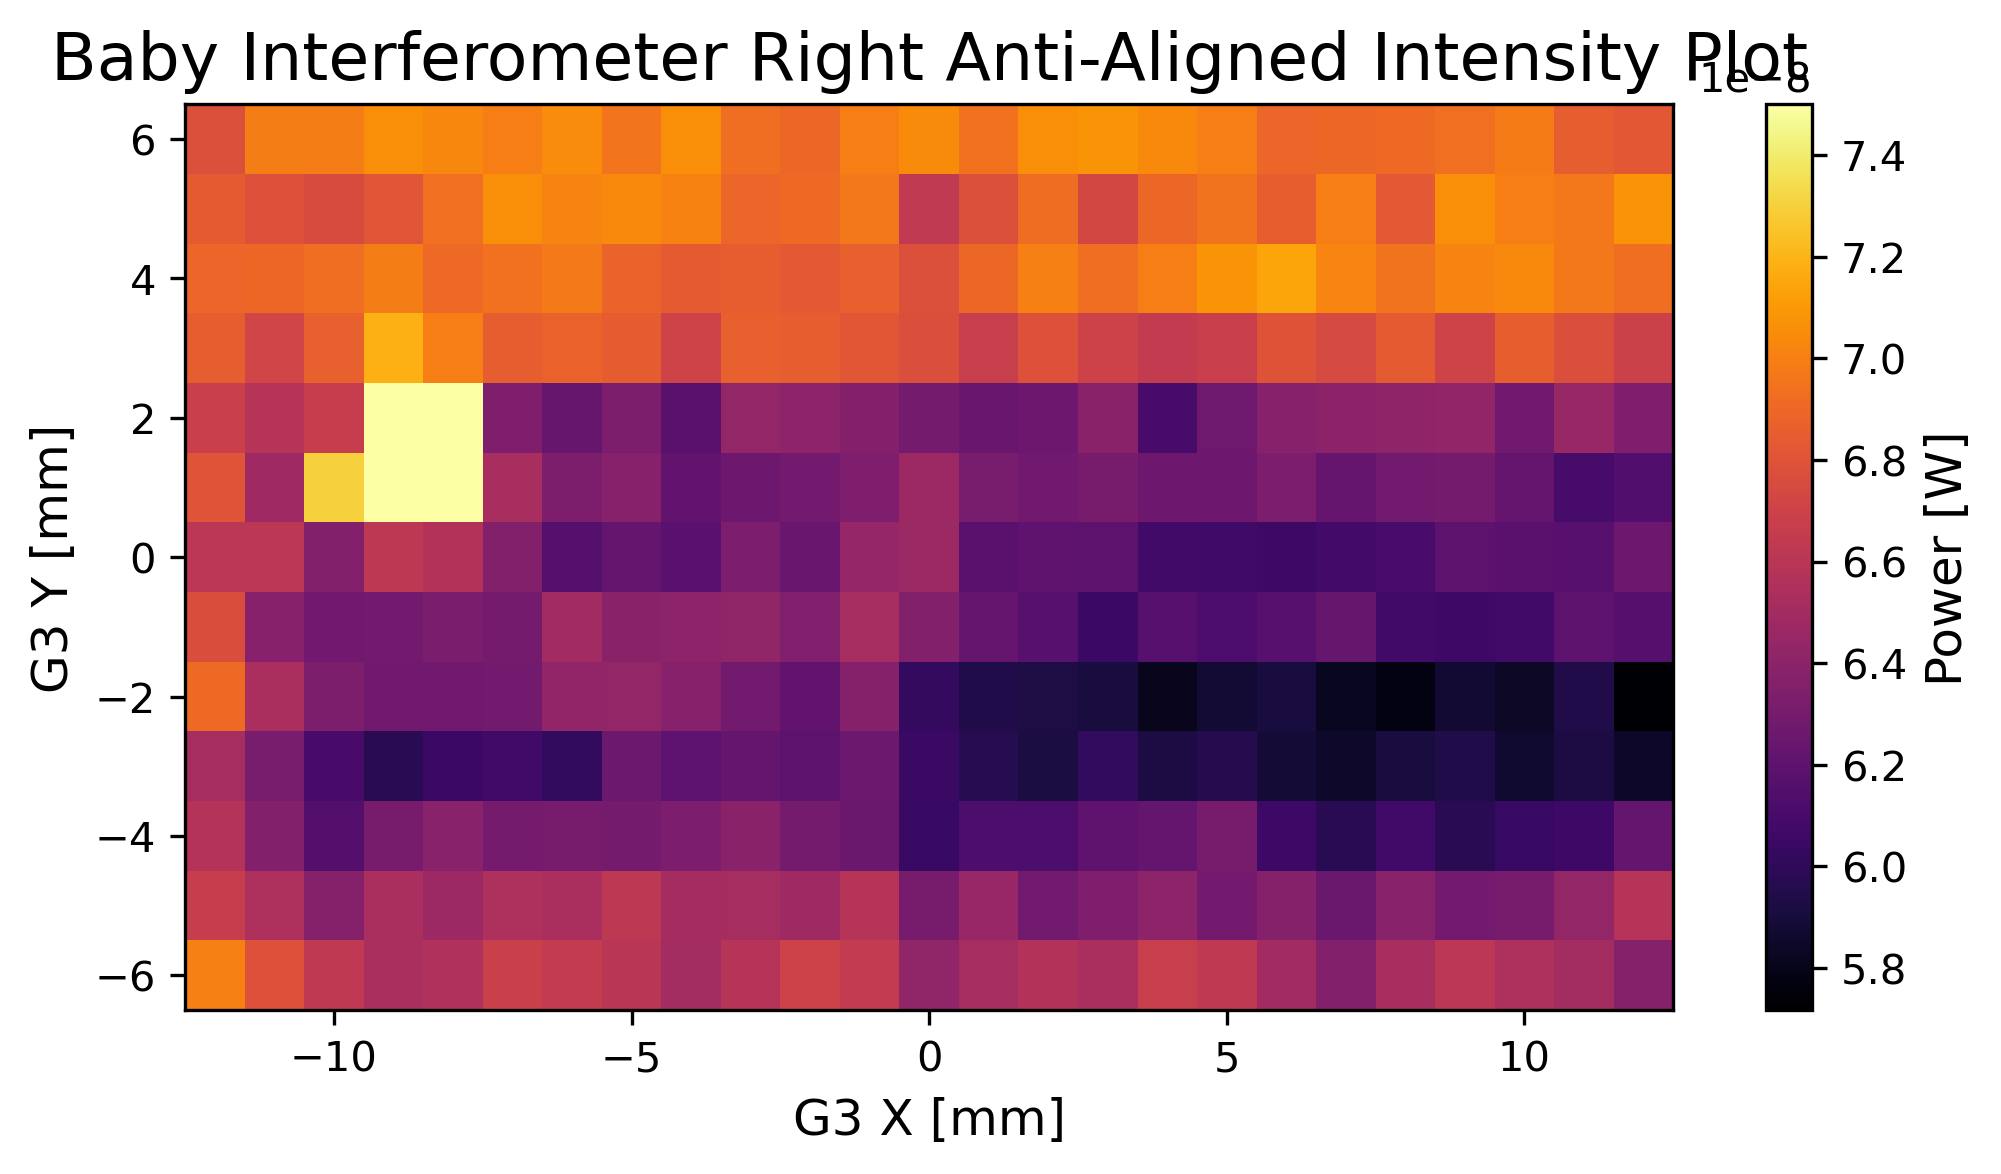

In [4]:
# Plot Aligned Intensity

fig = plt.figure(figsize=figure_size, dpi=300)
power_map = plt.pcolormesh(
    np.negative(x_values) * 0.25e-3,
    np.negative(y_values) * 0.05e-3,
    np.transpose(
        (q.MeasurementArray(power_array_aligned.flatten()).values).reshape(x_len, y_len)
    ),
    cmap="inferno",
    shading="nearest",
    # vmin=0.,
    vmax=0.00052,
)
plt.title(
    "{} Aligned Intensity Plot".format(sample_name),
    size=16,
)
plt.ylabel("G3 Y [mm]", size=12)
plt.xlabel("G3 X [mm]", size=12)
plt.colorbar(power_map).ax.set_ylabel("Power [W]", size=12)
if save_figures:
    plt.savefig(
        "figures/{}/rotation/intensity_aligned.png".format(folder_name),
        facecolor="white",
    )
plt.show()


# Plot Anti Aligned Intensity

fig = plt.figure(figsize=figure_size, dpi=300)
power_map = plt.pcolormesh(
    np.negative(x_values) * 0.25e-3,
    np.negative(y_values) * 0.05e-3,
    np.transpose(
        (q.MeasurementArray(power_array_antialigned.flatten()).values).reshape(
            x_len, y_len
        )
    ),
    cmap="inferno",
    shading="nearest",
    # vmin=0.,
    vmax=7.5e-8,
)
plt.title(
    "{} Anti-Aligned Intensity Plot".format(sample_name),
    size=16,
)
plt.ylabel("G3 Y [mm]", size=12)
plt.xlabel("G3 X [mm]", size=12)
plt.colorbar(power_map).ax.set_ylabel("Power [W]", size=12)
if save_figures:
    plt.savefig(
        "figures/{}/rotation/intensity_antialigned.png".format(folder_name),
        facecolor="white",
    )
plt.show()

### Compute average values of birefringence parameters

Set x_slice and y_slice to the boundaries of the sample. 
Selecting a subsection of the sample containing only regions certain to contain the sample may yield better results. 

Determine the region visually using a transmission plot generated above [here](#intensity-plot-generator). These are also set in this [config](#config).

In [29]:
# x_slice = slice(None)
# y_slice = slice(None)

alpha_final = slice_q(qalpha, x_slice, y_slice, (x_len, y_len))
beta_final = slice_q(qbeta, x_slice, y_slice, (x_len, y_len))
birefringence_final = beta_final * l / (2 * np.pi * d)
beta_final = beta_final * 180 / np.pi
depolarization_final = slice_q(qdepolarization, x_slice, y_slice, (x_len, y_len))


print("x: {}, y: {}\n".format(x_slice, y_slice))
print("alpha: {}\n".format(alpha_final.mean()))
print("alpha std: {}\n".format(np.std(alpha_final.values)))
print("beta: {}\n".format(beta_final.mean()))
print("beta std: {}\n".format(np.std(beta_final.values)))
print("birefringence: {}\n".format(birefringence_final.mean()))
print("birefringence std: {}\n".format(np.std(birefringence_final.values)))
print("depolarization: {}\n".format(depolarization_final.mean()))
print("depolarization std: {}\n".format(np.std(depolarization_final.values)))

x: slice(None, None, None), y: slice(None, None, None)

alpha: 38.9 +/- 0.9

alpha std: 16.69003105701209

beta: 0.89 +/- 0.05

beta std: 0.9290542320323186

birefringence: 0.000064 +/- 0.000004

birefringence std: 6.666824350231914e-05

depolarization: 0.0017 +/- 0.0002

depolarization std: 0.0032827588174763134



# Additional Plots

### "Noise" of Empty Space

[DerivedValue(0.00246 +/- 0.00001) DerivedValue(0.00237 +/- 0.00001)
 DerivedValue(0.00232 +/- 0.00001) DerivedValue(0.00232 +/- 0.00001)
 DerivedValue(0.00226 +/- 0.00001) DerivedValue(0.00227 +/- 0.00001)
 DerivedValue(0.00230 +/- 0.00001) DerivedValue(0.00217 +/- 0.00001)
 DerivedValue(0.00221 +/- 0.00001) DerivedValue(0.00219 +/- 0.00001)
 DerivedValue(0.002138 +/- 0.000009) DerivedValue(0.00221 +/- 0.00001)
 DerivedValue(0.00226 +/- 0.00001) DerivedValue(0.00220 +/- 0.00001)
 DerivedValue(0.00224 +/- 0.00001) DerivedValue(0.00221 +/- 0.00001)
 DerivedValue(0.00210 +/- 0.00001) DerivedValue(0.002142 +/- 0.000009)
 DerivedValue(0.00205 +/- 0.00001) DerivedValue(0.002079 +/- 0.000007)
 DerivedValue(0.002143 +/- 0.000009) DerivedValue(0.002094 +/- 0.000009)
 DerivedValue(0.002076 +/- 0.000008) DerivedValue(0.00212 +/- 0.00001)
 DerivedValue(0.002201 +/- 0.000009) DerivedValue(0.00227 +/- 0.00001)
 DerivedValue(0.00228 +/- 0.00001) DerivedValue(0.00233 +/- 0.00001)
 DerivedValue(0.0023

TypeError: float() argument must be a string or a real number, not 'DerivedValue'

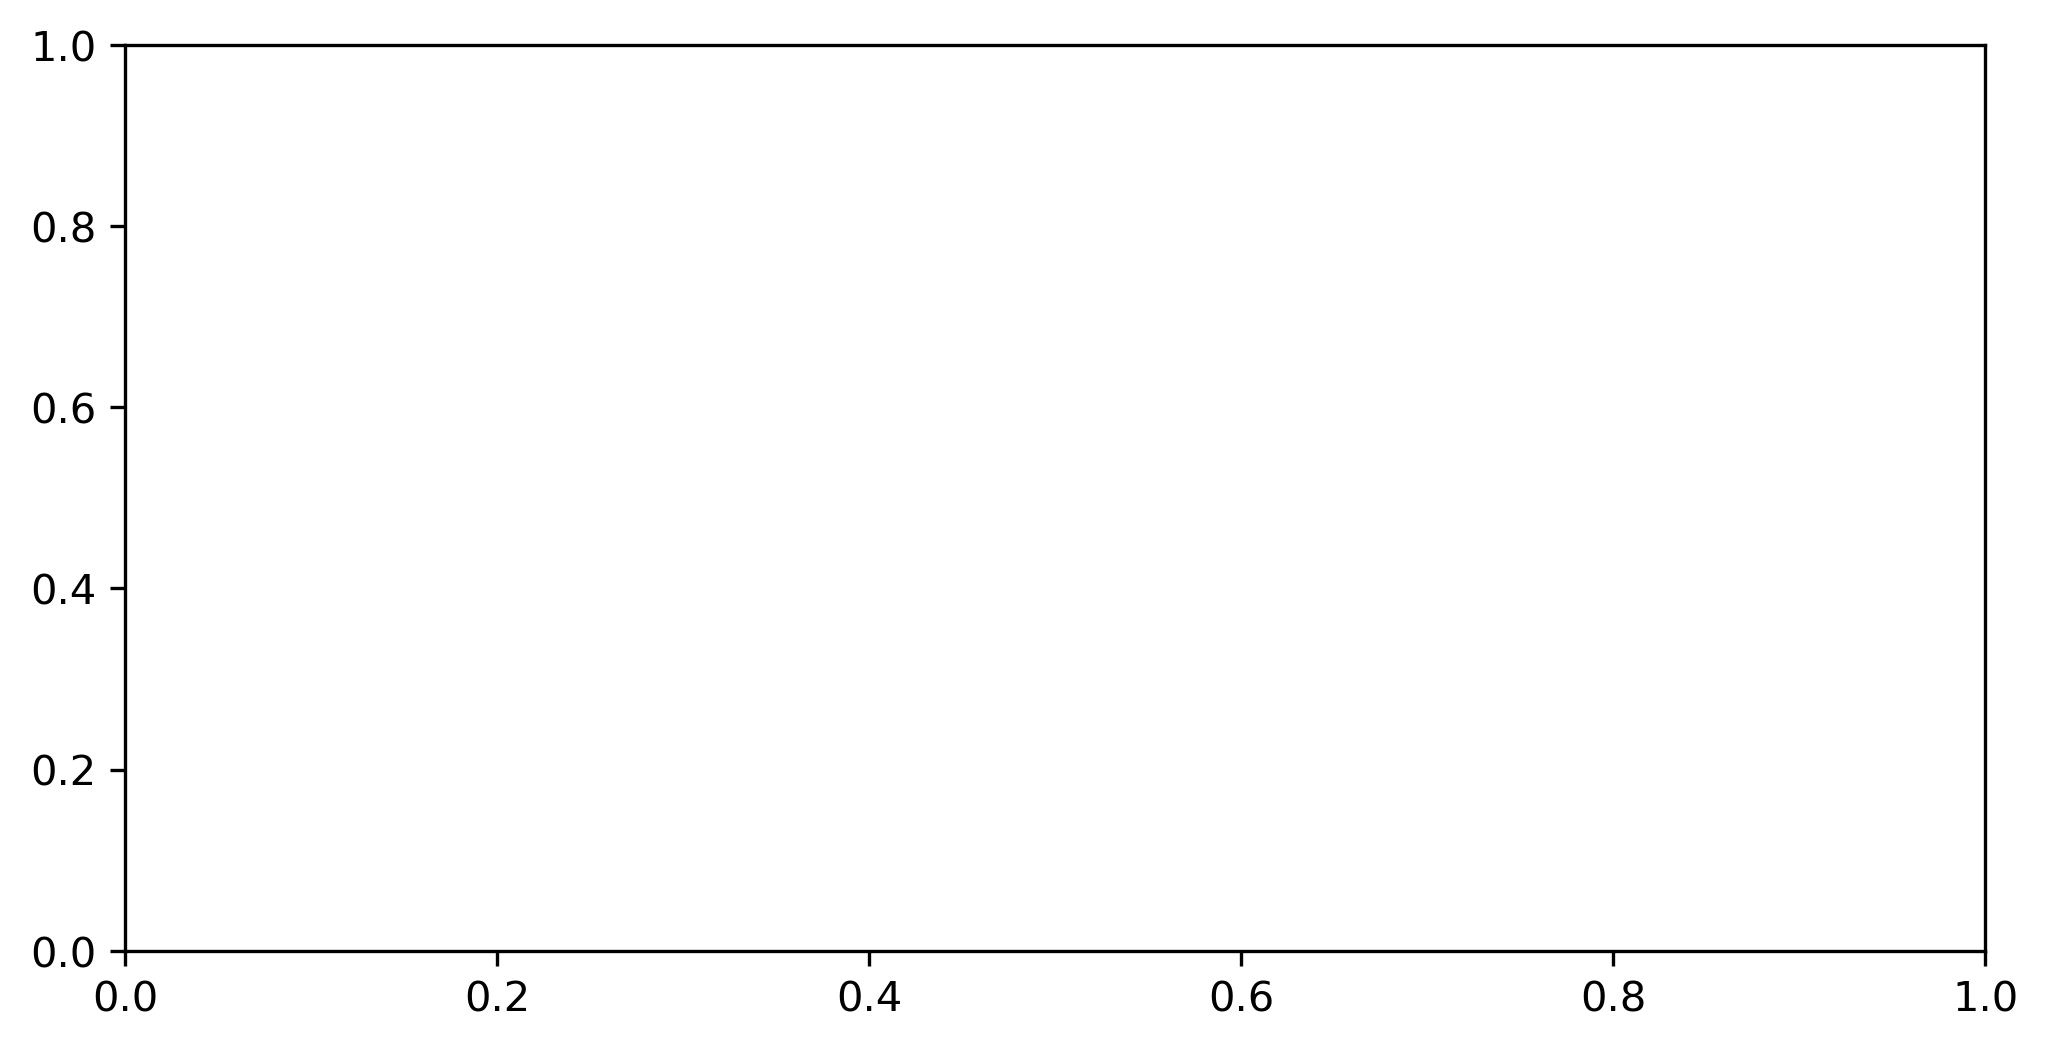

In [30]:
depolarization_noise = np.mean(transmittance_array[0, :, 1:-1], axis=0)
print(depolarization_noise)

fig = plt.figure(figsize=(8, 4), dpi=300)

for i in np.arange(transmittance_array[0, :, :].shape[0]):
    plt.plot(np.arange(5, 185, 5), transmittance_array[0, i, 1:-1], "b-")
plt.plot(np.arange(5, 185, 5), depolarization_noise, "r-")
plt.xlabel("Angle [deg]", size=12)
plt.ylabel("Depolarization", size=12)
plt.title("Not Noise? Double Frequency Something???", size=16)
plt.show()

In [ ]:
# TODO (Tim): add labels, titles, and details; save fig.
aligned = []
antialigned = []
for angle_aligned, angle_antialigned in zip(
    polarizer_aligned_angle, polarizer_antialigned_angle
):
    antialigned_temp = scan_df_antialigned["Power - Mean [W]"][
        np.array(scan_df_antialigned["G3 Y Translation"] == y_values[0])
        & np.array(scan_df_antialigned["G3 X Translation"] == x_values[0])
        & np.array(scan_df_antialigned["Polarizer [deg]"] == angle_antialigned)
    ]
    aligned_temp = scan_df_aligned["Power - Mean [W]"][
        np.array(scan_df_aligned["G3 Y Translation"] == y_values[0])
        & np.array(scan_df_aligned["G3 X Translation"] == x_values[0])
        & np.array(scan_df_aligned["Polarizer [deg]"] == angle_aligned)
    ]

    aligned.append(aligned_temp.values)
    antialigned.append(antialigned_temp.values)
fig = plt.figure(figsize=(8, 4), dpi=300)
plt.plot(np.arange(0, 185, 5), np.array(aligned) / 2000, "ro--")
plt.plot(np.arange(0, 185, 5), np.array(antialigned), "go--")
plt.show()
# label

## Transmittance Curves

Plots multiple transmittance curves from across the sample

In [ ]:
xydata = q.XYDataSet(
    xdata=np.arange(0, 185, 5),
    # xerr=0.001,
    xunit="deg",
    xname="angle",
    ydata=transmittance_array[5][5][1:],
    yunit="",
    yname="transmittance",
)
result = xydata.fit(
    model=transmittance,
    parguess=[np.pi / 4, 45, 0.01],
    bounds=([1e-5, 1e-5, 0], [2 * np.pi, 90, 1]),
)
b = result.params[0]
a = result.params[1]
D = result.params[2]

fig = qplt.plot(xydata)
fig.plot(result)
fig.title = "({})".format(result.params)
for i in np.arange(10):
    for j in np.arange(10):
        xydata = q.XYDataSet(
            xdata=np.arange(0, 185, 5),
            # xerr=0.001,
            xunit="deg",
            xname="angle",
            ydata=transmittance_array[i][j][1:],
            yunit="",
            yname="transmittance",
        )
    fig.plot(xydata)
fig.show()